In [29]:
import numpy as np
from tensorflow import keras
from skimage.feature import hog
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import cv2

# Data Preprocessing

In [30]:
#Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

#HOG feature extraction
def preprocess(xs):
    hog_features = []
    for x in xs:
        # Convert to grayscale
        x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) / 255
        h_x = hog(x, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        hog_features.append(h_x)
    return np.array(hog_features)

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [31]:
# Standardize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#PCA
pca = PCA(n_components=0.8)  # Choose the minimum number of components  so that the cumulative variance ≥ 80%.
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)


## Balanced subset for GridSearch

In [32]:
x_balanced = []
y_balanced = []
for i in range(10):
    j = 0
    k = 0;
    while(j!=1000):
        if y_train[k] == i:
            x_balanced.append(x_train_pca[k])
            y_balanced.append(i)
            j+=1    
        k+=1
y_balanced = np.array(y_balanced)
x_balanced = np.array(x_balanced)
np.unique(y_balanced, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       dtype=int64))

In [33]:
#shuffle
from sklearn.utils import shuffle
x_balanced,y_balanced =  shuffle(x_balanced, y_balanced, random_state=42)

# GridSearch

In [34]:
#SGD
from sklearn.model_selection import GridSearchCV

param_grid = {
    'loss': ['hinge', 'log_loss'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'penalty': ['l2', 'l1'],
    'max_iter': [1000],
    'tol': [1e-3]
}

sgd = SGDClassifier(random_state=42)
grid = GridSearchCV(sgd, param_grid, cv=3, n_jobs=-1)
grid.fit(x_balanced, y_balanced)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Best params: {'alpha': 0.001, 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}
Best score: 0.46579945937005224


In [35]:
#SVC
param_grid = {
    'C': [1, 10,25,50,100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

svc = SVC(random_state=42)
grid2 = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1,verbose = 3)
grid2.fit(x_balanced, y_balanced)

print("Best params:", grid2.best_params_)
print("Best score:", grid2.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5497000509889022


# Model Training

In [36]:
#SGDClassifier
model_sgdc = SGDClassifier(**grid.best_params_, random_state=42)
model_sgdc.fit(x_train_pca, y_train)

SGDClassifier(alpha=0.001, loss='log_loss', random_state=42)

In [38]:
#rbf SVC
model_rbf_svc = SVC(**grid2.best_params_,random_state=42)
model_rbf_svc.fit(x_train_pca, y_train)

SVC(C=1, random_state=42)

# Evaluations

In [43]:
accuracy_rbf_svc = model_rbf_svc.score(x_test_pca, y_test)
print(f"Test Accuracy for rbf SVC: {accuracy_rbf_svc:.2f}")

accuracy_sgdc = model_sgdc.score(x_test_pca, y_test)
print(f"Test Accuracy for SGD: {accuracy_sgdc:.2f}")

Test Accuracy for rbf SVC: 0.62
Test Accuracy for SGD: 0.48


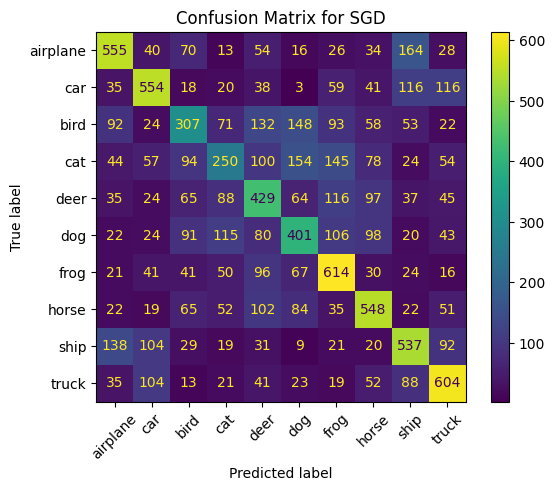

In [44]:
#Confusion matrix1
y_pred = model_sgdc.predict(x_test_pca)
labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix for SGD")
plt.xticks(rotation=45)
plt.show()

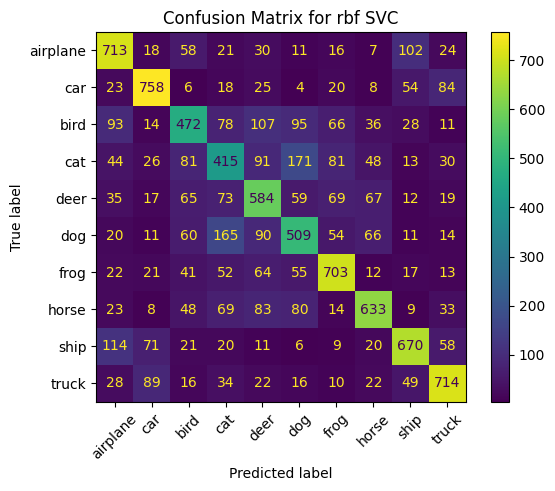

In [45]:
#Confusion matrix2
y_pred = model_rbf_svc.predict(x_test_pca)
labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix for rbf SVC")
plt.xticks(rotation=45)
plt.show()